#### Load libraries, set CUDA device, and load results

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.distributions import Poisson, Normal, Uniform, Distribution, Categorical

import numpy as np
import sep

In [2]:
# torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

In [3]:
# Synthetic images
s = torch.load('s.pt', map_location=lambda storage, loc: storage.cuda(device.index))
flux = torch.load('flux.pt', map_location=lambda storage, loc: storage.cuda(device.index))
u = torch.load('u.pt', map_location=lambda storage, loc: storage.cuda(device.index))
true_intensity = torch.load('true_intensity.pt', map_location=lambda storage, loc: storage.cuda(device.index))
images = torch.load('images.pt', map_location=lambda storage, loc: storage.cuda(device.index))
num_images = images.size(0)
D = flux.size(1)

# SEP results
sep_estimated_s = torch.load('sep_estimated_s.pt', map_location=lambda storage, loc: storage.cuda(device.index))
sep_reconstruction = torch.load('sep_reconstruction.pt', map_location=lambda storage, loc: storage.cuda(device.index))

# SMC results
post_mean_s_smc = torch.load('post_mean_s_smc.pt', map_location=lambda storage, loc: storage.cuda(device.index))
prob_s_smc = torch.load('prob_s_smc.pt', map_location=lambda storage, loc: storage.cuda(device.index))
num_iters_smc = torch.load('num_iters_smc.pt', map_location=lambda storage, loc: storage.cuda(device.index))
reconstruction_smc = torch.load('reconstruction_smc.pt', map_location=lambda storage, loc: storage.cuda(device.index))

----
----
----

#### SEP results

In [4]:
sep_prop_correct = ((sep_estimated_s == s).sum()/num_images)
sep_mse = ((sep_estimated_s - s)**2).mean()
sep_mae = (sep_estimated_s - s).abs().mean()

print("SEP results:")
print(f"proportion correct = {sep_prop_correct}")
print(f"MSE = {sep_mse}")
print(f"MAE = {sep_mae}")

SEP results:
proportion correct = 0.20900000631809235
MSE = 20.64000129699707
MAE = 3.5420000553131104


In [5]:
sep_mean_estimated_s_by_num = torch.zeros(D, device=device)
sep_bounds_estimated_s_by_num = torch.zeros(D, 2, device=device)
sep_num_correct_by_num = torch.zeros(D, device=device)
sep_prop_correct_by_num = torch.zeros(D, device=device)
sep_mse_by_num = torch.zeros(D, device=device)
sep_mae_by_num = torch.zeros(D, device=device)
sep_bounds_mae_by_num = torch.zeros(D, 2, device=device)

for num in range(D):
    print(f"true number of sources = {num}")
    sep_mean_estimated_s_by_num[num] = sep_estimated_s[s==num].mean()
    print(f"mean estimated number of sources = {sep_mean_estimated_s_by_num[num].item()}")
    sep_bounds_estimated_s_by_num[num] = sep_estimated_s[s==num].quantile(torch.tensor((0.05, 0.95),device=device))
    
    sep_mse_by_num[num] = ((sep_estimated_s[s==num] - s[s==num])**2).mean()
    print(f"MSE across {num_images} images = ", sep_mse_by_num[num].item())
    
    sep_mae_by_num[num] = ((sep_estimated_s[s==num] - s[s==num]).abs()).mean()
    print(f"MAE across {num_images} images = ", sep_mae_by_num[num].item())
    sep_bounds_mae_by_num[num] = ((sep_estimated_s[s==num] - s[s==num]).abs()).quantile(torch.tensor((0.05, 0.95),device=device))
    
    sep_num_correct_by_num[num] = (sep_estimated_s[s==num].round() == s[s==num]).sum()
    sep_prop_correct_by_num[num] = sep_num_correct_by_num[num]/(s==num).sum()
    print(f"correct number of sources detected in {sep_num_correct_by_num[num]} of the {(s==num).sum()} images (accuracy = {sep_prop_correct_by_num[num]})\n\n\n")

true number of sources = 0
mean estimated number of sources = 0.0
MSE across 1000 images =  0.0
MAE across 1000 images =  0.0
correct number of sources detected in 96.0 of the 96 images (accuracy = 1.0)



true number of sources = 1
mean estimated number of sources = 0.9054054021835327
MSE across 1000 images =  0.09459459781646729
MAE across 1000 images =  0.09459459781646729
correct number of sources detected in 67.0 of the 74 images (accuracy = 0.9054054021835327)



true number of sources = 2
mean estimated number of sources = 1.4186046123504639
MSE across 1000 images =  0.604651153087616
MAE across 1000 images =  0.604651153087616
correct number of sources detected in 34.0 of the 86 images (accuracy = 0.39534884691238403)



true number of sources = 3
mean estimated number of sources = 1.711538553237915
MSE across 1000 images =  2.076923131942749
MAE across 1000 images =  1.2884615659713745
correct number of sources detected in 11.0 of the 104 images (accuracy = 0.10576923191547394

----
----
----

#### SMC-Deblender results

In [6]:
print(f"MSE across {num_images} images:", ((post_mean_s_smc - s)**2).mean().item())
print(f"MAE across {num_images} images:", ((post_mean_s_smc - s).abs()).mean().item())
print(f"correct number of sources detected in {(post_mean_s_smc.round() == s).sum()} of the {num_images} images (accuracy = {(post_mean_s_smc.round() == s).sum()/num_images})")
print(f"number of iterations: minimum = {num_iters_smc.min().int()}, median = {num_iters_smc.median().int()}, maximum = {num_iters_smc.max().int()}\n\n\n")

for i in range(num_images):
    print(f"image {i+1} of {num_images} took {num_iters_smc[i].int()} iterations:   ",
        "true s =", s[i].int().item(),
        "   estimated s =", "{:.3f}".format(post_mean_s_smc[i].round(decimals = 4).item()),
        "   absolute error:", "{:.3f}".format((post_mean_s_smc[i] - s[i]).abs().item()),
        "   total flux:", flux[i].sum().round().int().item())

MSE across 1000 images: 0.21501027047634125
MAE across 1000 images: 0.2666688561439514
correct number of sources detected in 765 of the 1000 images (accuracy = 0.76500004529953)
number of iterations: minimum = 67, median = 76, maximum = 525



image 1 of 1000 took 69 iterations:    true s = 4    estimated s = 4.079    absolute error: 0.079    total flux: 269012
image 2 of 1000 took 125 iterations:    true s = 6    estimated s = 6.523    absolute error: 0.523    total flux: 394558
image 3 of 1000 took 72 iterations:    true s = 2    estimated s = 2.000    absolute error: 0.000    total flux: 138994
image 4 of 1000 took 93 iterations:    true s = 8    estimated s = 8.099    absolute error: 0.099    total flux: 551436
image 5 of 1000 took 69 iterations:    true s = 3    estimated s = 2.718    absolute error: 0.282    total flux: 162045
image 6 of 1000 took 110 iterations:    true s = 9    estimated s = 9.316    absolute error: 0.316    total flux: 578354
image 7 of 1000 took 131 iteration

In [7]:
smc_mean_post_mean_s_by_num = torch.zeros(D, device=device)
smc_bounds_post_mean_s_by_num = torch.zeros(D, 2, device=device)
smc_num_correct_by_num = torch.zeros(D, device=device)
smc_prop_correct_by_num = torch.zeros(D, device=device)
smc_mse_by_num = torch.zeros(D, device=device)
smc_mae_by_num = torch.zeros(D, device=device)
smc_bounds_mae_by_num = torch.zeros(D, 2, device=device)

for num in range(D):
    print(f"true number of sources = {num}")
    
    smc_mean_post_mean_s_by_num[num] = post_mean_s_smc[s==num].mean()
    print(f"estimated number of sources for images where s = {num}:", smc_mean_post_mean_s_by_num[num].item())
    smc_bounds_post_mean_s_by_num[num] = post_mean_s_smc[s==num].quantile(torch.tensor((0.05, 0.95),device=device))
    
    smc_mse_by_num[num] = ((post_mean_s_smc[s==num] - s[s==num])**2).mean()
    print(f"MSE across {(s==num).sum()} images:", (smc_mse_by_num[num].item()))
    
    smc_mae_by_num[num] = ((post_mean_s_smc[s==num] - s[s==num]).abs()).mean()
    print(f"MAE across {(s==num).sum()} images:", (smc_mae_by_num[num].item()))
    smc_bounds_mae_by_num[num] = ((post_mean_s_smc[s==num] - s[s==num]).abs()).quantile(torch.tensor((0.05, 0.95),device=device))
    
    smc_num_correct_by_num[num] = (post_mean_s_smc[s==num].round() == s[s==num]).sum()
    smc_prop_correct_by_num[num] = smc_num_correct_by_num[num]/(s==num).sum()
    print(f"correct number of sources detected in {smc_num_correct_by_num[num].int()} of the {(s==num).sum()} images (accuracy = {smc_prop_correct_by_num[num]})")
    
    print(f"number of iterations: minimum = {num_iters_smc[s==num].min().int()}, median = {num_iters_smc[s==num].median().int()}, maximum = {num_iters_smc[s==num].max().int()}\n")

true number of sources = 0
estimated number of sources for images where s = 0: 9.568190762365703e-06
MSE across 96 images: 1.0450780241200164e-09
MAE across 96 images: 9.568190762365703e-06
correct number of sources detected in 96 of the 96 images (accuracy = 1.0)
number of iterations: minimum = 72, median = 73, maximum = 78

true number of sources = 1
estimated number of sources for images where s = 1: 1.0007916688919067
MSE across 74 images: 1.2940417946083471e-05
MAE across 74 images: 0.0007915400201454759
correct number of sources detected in 74 of the 74 images (accuracy = 1.0)
number of iterations: minimum = 71, median = 72, maximum = 75

true number of sources = 2
estimated number of sources for images where s = 2: 2.0019948482513428
MSE across 86 images: 0.001954036997631192
MAE across 86 images: 0.010105720721185207
correct number of sources detected in 86 of the 86 images (accuracy = 1.0)
number of iterations: minimum = 70, median = 71, maximum = 76

true number of sources = 

----
----
----

#### Bootstrap percentile CIs for panel (a) of figure 1

In [8]:
torch.manual_seed(0)

### SMC
num_boot_samples = 10000
smc_bounds_prop_correct_by_num = torch.zeros(D, 2, device=device)

for num in range(D):
    boot_orig = torch.stack((post_mean_s_smc[s==num].round(), s[s==num]), dim = 1)
    boot_prop_correct = torch.zeros(num_boot_samples, device=device)
    
    for j in range(num_boot_samples):
        boot_sample = boot_orig[(torch.multinomial(torch.arange(boot_orig.size(0)).double(), num_samples = boot_orig.size(0), replacement = True))]
        boot_prop_correct[j] = (boot_sample[:,0] == boot_sample[:,1]).sum()/boot_orig.size(0)
    
    smc_bounds_prop_correct_by_num[num] = boot_prop_correct.quantile(torch.tensor((0.05, 0.95),device=device))

### SEP
sep_bounds_prop_correct_by_num = torch.zeros(D, 2, device=device)

for num in range(D):
    boot_orig = torch.stack((sep_estimated_s[s==num].round(), s[s==num]), dim = 1)
    boot_prop_correct = torch.zeros(num_boot_samples, device=device)
    
    for j in range(num_boot_samples):
        boot_sample = boot_orig[(torch.multinomial(torch.arange(boot_orig.size(0)).double(), num_samples = boot_orig.size(0), replacement = True))]
        boot_prop_correct[j] = (boot_sample[:,0] == boot_sample[:,1]).sum()/boot_orig.size(0)
    
    sep_bounds_prop_correct_by_num[num] = boot_prop_correct.quantile(torch.tensor((0.05, 0.95),device=device))

----
----
----

#### Figure 1

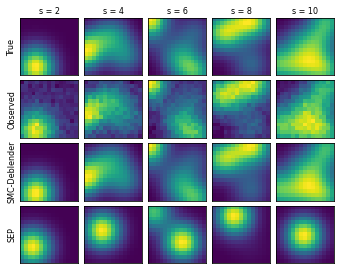

In [9]:
torch.manual_seed(100)

# Plot true intensities vs observed intensities vs SMC reconstruction
example_image_indexes = [torch.arange(num_images,device=device)[s==2][torch.randint(low=0, high=(s==2).sum(), size=(1,))].item(),
                         torch.arange(num_images,device=device)[s==4][torch.randint(low=0, high=(s==4).sum(), size=(1,))].item(),
                         torch.arange(num_images,device=device)[s==6][torch.randint(low=0, high=(s==6).sum(), size=(1,))].item(),
                         torch.arange(num_images,device=device)[s==8][torch.randint(low=0, high=(s==8).sum(), size=(1,))].item(),
                         torch.arange(num_images,device=device)[s==10][torch.randint(low=0, high=(s==10).sum(), size=(1,))].item()]
fig1_s = s[example_image_indexes]
fig1_true = true_intensity[example_image_indexes]
fig1_observed = images[example_image_indexes]
fig1_smc = reconstruction_smc[example_image_indexes]
fig1_sep = sep_reconstruction[example_image_indexes]

fig1,method = plt.subplots(nrows = 4, ncols = 5, sharex = True, sharey = True)
fig1.tight_layout(h_pad = -0.5, w_pad = -0.5)

for i in range(5):
    _ = method[0,i].imshow(fig1_true[i].cpu())
    _ = method[0,i].set_xlabel(f"s = {fig1_s[i].int()}", fontsize = 8)
    _ = method[0,i].xaxis.set_label_position("top")
    _ = method[0,i].set_xticks([])
    _ = method[0,i].set_yticks([])

    _ = method[1,i].imshow(fig1_observed[i].cpu())
    _ = method[1,i].set_xticks([])
    _ = method[1,i].set_yticks([])

    _ = method[2,i].imshow(fig1_smc[i].cpu())
    _ = method[2,i].set_xticks([])
    _ = method[2,i].set_yticks([])

    _ = method[3,i].imshow(fig1_sep[i].cpu())
    _ = method[3,i].set_xticks([])
    _ = method[3,i].set_yticks([])

_ = method[0,0].set_ylabel("True", loc = "center", fontsize = 8)
_ = method[1,0].set_ylabel("Observed", loc = "center", fontsize = 8)
_ = method[2,0].set_ylabel("SMC-Deblender", loc = "center", fontsize = 8)
_ = method[3,0].set_ylabel("SEP", loc = "center", fontsize = 8)

fig1.subplots_adjust(wspace=-0.5)
fig1.savefig('fig1.png', dpi=500)

----
----
----

#### Figure 2

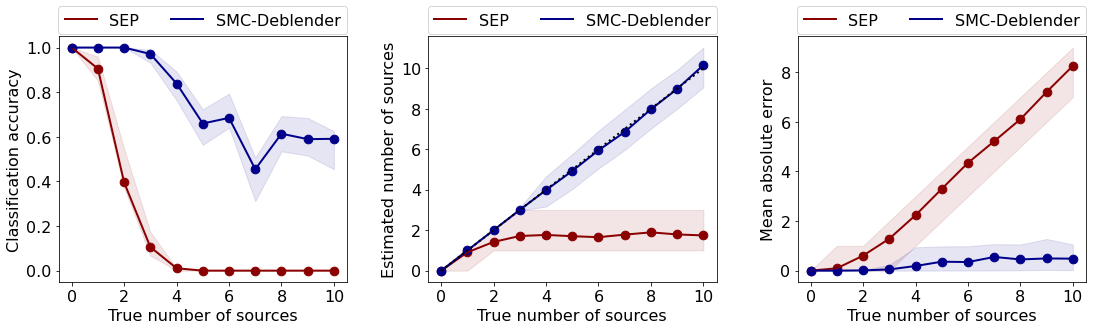

In [10]:
dot_size = 75
line_width = 2
text_size = 16
sep_color = "darkred"
smc_color = "darkblue"

fig2, (fig2a,fig2b,fig2c) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
fig2.tight_layout(w_pad = 5)

_ = fig2a.plot(torch.arange(D), sep_prop_correct_by_num.cpu(), label = "SEP", color = sep_color, linewidth = line_width)
_ = fig2a.scatter(torch.arange(D), sep_prop_correct_by_num.cpu(), color = sep_color, s = dot_size)
_ = fig2a.fill_between(torch.arange(D), sep_bounds_prop_correct_by_num[:,0].cpu(), sep_bounds_prop_correct_by_num[:,1].cpu(), color = sep_color, alpha = 0.1)
_ = fig2a.plot(torch.arange(D), smc_prop_correct_by_num.cpu(), label = "SMC-Deblender", color = smc_color, linewidth = line_width)
_ = fig2a.scatter(torch.arange(D), smc_prop_correct_by_num.cpu(), color = smc_color, s = dot_size)
_ = fig2a.fill_between(torch.arange(D), smc_bounds_prop_correct_by_num[:,0].cpu(), smc_bounds_prop_correct_by_num[:,1].cpu(), color = smc_color, alpha = 0.1)
_ = fig2a.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
_ = fig2a.tick_params(axis = "both", labelsize = text_size)
_ = fig2a.set_xlabel("True number of sources", fontsize = text_size)
_ = fig2a.set_ylabel("Classification accuracy", fontsize = text_size)

_ = fig2b.plot(torch.arange(D), sep_mean_estimated_s_by_num.cpu(), color = sep_color, label = "SEP", linewidth = line_width)
_ = fig2b.scatter(torch.arange(D), sep_mean_estimated_s_by_num.cpu(), color = sep_color, s = dot_size)
_ = fig2b.fill_between(torch.arange(D), sep_bounds_estimated_s_by_num[:,0].cpu(), sep_bounds_estimated_s_by_num[:,1].cpu(), color = sep_color, alpha = 0.1)
_ = fig2b.plot(torch.arange(D), smc_mean_post_mean_s_by_num.cpu(), color = smc_color, label = "SMC-Deblender", linewidth = line_width)
_ = fig2b.scatter(torch.arange(D), smc_mean_post_mean_s_by_num.cpu(), color = smc_color, s = dot_size)
_ = fig2b.fill_between(torch.arange(D), smc_bounds_post_mean_s_by_num[:,0].cpu(), smc_bounds_post_mean_s_by_num[:,1].cpu(), color = smc_color, alpha = 0.1)
_ = fig2b.plot(torch.arange(D), torch.arange(D), ":", color="black", linewidth = line_width)
_ = fig2b.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
_ = fig2b.tick_params(axis = "both", labelsize = text_size)
_ = fig2b.set_xlabel("True number of sources", fontsize = text_size)
_ = fig2b.set_ylabel("Estimated number of sources", fontsize = text_size)

_ = fig2c.plot(torch.arange(D), (sep_mae_by_num + smc_mae_by_num[0]).cpu(), label = "SEP", color = sep_color, linewidth = line_width)
_ = fig2c.scatter(torch.arange(D), sep_mae_by_num.cpu(), color = sep_color, s = dot_size)
_ = fig2c.fill_between(torch.arange(D), sep_bounds_mae_by_num[:,0].cpu(), sep_bounds_mae_by_num[:,1].cpu(), color = sep_color, alpha = 0.1)
_ = fig2c.plot(torch.arange(D), (smc_mae_by_num).cpu(), label = "SMC-Deblender", color = smc_color, linewidth = line_width)
_ = fig2c.scatter(torch.arange(D), smc_mae_by_num.cpu(), color = smc_color, s = dot_size)
_ = fig2c.fill_between(torch.arange(D), smc_bounds_mae_by_num[:,0].cpu(), smc_bounds_mae_by_num[:,1].cpu(), color = smc_color, alpha = 0.1)
_ = fig2c.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
_ = fig2c.tick_params(axis = "both", labelsize = text_size)
_ = fig2c.set_xlabel("True number of sources", fontsize = text_size)
_ = fig2c.set_ylabel("Mean absolute error", fontsize = text_size)

fig2.savefig('fig2.png', bbox_inches = "tight", dpi = 500)